# ¿Qué valor de mercado debe tener tu auto?

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- La calidad de la predicción.
- La velocidad de la predicción.
- El tiempo requerido para el entrenamiento

**Tabla de contenido:**

1. Inicialización
2. Carga de datos
3. Análisis de datos
4. Preparación de datos
5. Entrenamiento del modelo
6. Análisis de modelos
7. Conclusiones

**Descripción del dataset del proyecto:**

**Features:**
- `DateCrawled` — fecha en la que se descargó el perfil de la base de datos
- `VehicleType` — tipo de carrocería del vehículo
- `RegistrationYear` — año de matriculación del vehículo
- `Gearbox` — tipo de caja de cambios
- `Power` — potencia (CV)
- `Model` — modelo del vehículo
- `Mileage` — kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
- `RegistrationMonth` — mes de matriculación del vehículo
- `FuelType` — tipo de combustible
- `Brand` — marca del vehículo
- `NotRepaired` — vehículo con o sin reparación
- `DateCreated` — fecha de creación del perfil
- `NumberOfPictures` — número de fotos del vehículo
- `PostalCode` — código postal del propietario del perfil (usuario)
- `LastSeen` — fecha de la última vez que el usuario estuvo activo

**Target:**

- `price`— precio (en euros)

## Inicialización

In [1]:
# Importar librerías
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode

from sklearn.linear_model import LogisticRegression

import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import time

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

## Carga de datos

In [2]:
# Cargar data
df = pd.read_csv("/datasets/car_data.csv")

In [3]:
# Crear función para cambiar nombres de columnas
def to_snake_case(name):
    name = name.replace(' ', '_')
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

# Renombrar columnas usando la función to_snake_case
df.columns = [to_snake_case(col) for col in df.columns]
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


## Análisis de datos

In [4]:
# Ver sample de data
df.sample(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
348416,09/03/2016 15:43,10800,sedan,2008,manual,136,c_klasse,150000,4,gasoline,mercedes_benz,no,09/03/2016 00:00,0,32339,06/04/2016 23:16
130696,21/03/2016 08:58,1600,coupe,2001,auto,129,c_klasse,150000,11,petrol,mercedes_benz,no,21/03/2016 00:00,0,45130,22/03/2016 13:48
152424,30/03/2016 11:53,3900,sedan,2003,manual,163,a4,150000,1,petrol,audi,no,30/03/2016 00:00,0,44534,03/04/2016 01:21
65614,01/04/2016 15:58,950,small,1998,manual,50,arosa,150000,10,petrol,seat,no,01/04/2016 00:00,0,27383,05/04/2016 11:44
270549,16/03/2016 15:48,3500,bus,2007,manual,94,zafira,150000,9,cng,opel,no,16/03/2016 00:00,0,14059,06/04/2016 17:47
91008,10/03/2016 23:55,4150,sedan,2000,auto,193,5er,150000,11,gasoline,bmw,no,10/03/2016 00:00,0,45897,06/04/2016 04:44
298742,19/03/2016 13:38,3250,bus,1994,manual,77,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,85764,21/03/2016 17:50
180169,04/04/2016 16:40,1000,wagon,1995,manual,136,e_klasse,150000,5,petrol,mercedes_benz,no,04/04/2016 00:00,0,4349,06/04/2016 18:16
284000,17/03/2016 09:48,700,NaN,2005,manual,75,ibiza,150000,2,NaN,seat,yes,17/03/2016 00:00,0,84367,21/03/2016 12:47
276392,27/03/2016 11:36,5100,wagon,2002,manual,229,a4,150000,2,petrol,audi,no,27/03/2016 00:00,0,51469,27/03/2016 11:36


In [5]:
# Verificar tipos de columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Los tipos de datos que hay algunas columnas que se registran con fechas, pero no están identíficadas correctamente, por lo cual se deberán cambiar más adelante. Asimismo, vemos columnas con resgistros nulos: vehicle_type, model, fuel_type y not_repaired.

In [6]:
# Verificar estadísticas descriptivas
df.describe()

,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Al parecer no hay ningún registro que contenga fotos, todos los registros son 0. Por otro lado, el máximo años de registro es 9999 y mínimo 1000, hay precios de autos iguales a 0 e igualmente ocurre con los datos del poder del mismo. Estos casos los revisaremos más detalle más adelante.

Ahora realizaremos el tipo de cambio a las columnas que resgistran fecha al tipo correcto.

In [7]:
# Cambiar columnas de fecha a tipo datetime %Y-%m-%d %H:%M:%S.%f
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format="%d/%m/%Y %H:%M")
df['date_created'] = pd.to_datetime(df['date_created'], format="%d/%m/%Y %H:%M")
df['last_seen'] = pd.to_datetime(df['last_seen'], format="%d/%m/%Y %H:%M")

df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   mileage             354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  not_repaired        283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

In [8]:
# Verificar cambios
df.sample(1)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
102515,2016-03-26 19:38:00,12100,wagon,2011,manual,105,caddy,60000,7,petrol,volkswagen,no,2016-03-26,0,38471,2016-03-28 08:44:00


Ahora filtraremos la columnas de "NumberOfPictures" de nuestra data debido a que esta es cero para todos los registros

In [9]:
# Filtrar "NumberOfPictures" del dataset
df = df.drop("number_of_pictures", axis=1)

# Comprobar cambios
df.sample(1)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
351692,2016-03-06 14:44:00,600,small,1997,manual,0,polo,150000,7,petrol,volkswagen,NaN,2016-03-06,61381,2016-03-07 18:34:00


Por último, analizaremos si contamos con registros duplicados.

In [10]:
# Ver registros duplicados
df.duplicated().sum()

262

Tenemos 262 duplicados, previo a eliminarlos primero trataremos los datos ausentes y luego eliminaremos estos.

Ya hemos realizado los cambios necesarios en primera instancia, pero hay datos nulos en columnas categóricas y datos atípicos en columnas numerícas. Examinaremos más a detalle estos datos.

Ahora veremos como se están ditribuyendo nuestros datos. Separaremos nuestro análisis en datos continuos o numéricos y datos categóricos para esto. En estos grupos no se consideran las columnas de tipo fecha.

In [11]:
# Determinar las columnas de tipo integer y float
numeric_columns = ['price', 'registration_year', 'power', 'mileage', 'registration_month', 'postal_code']

categorical_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

### Análisis variables numéricas

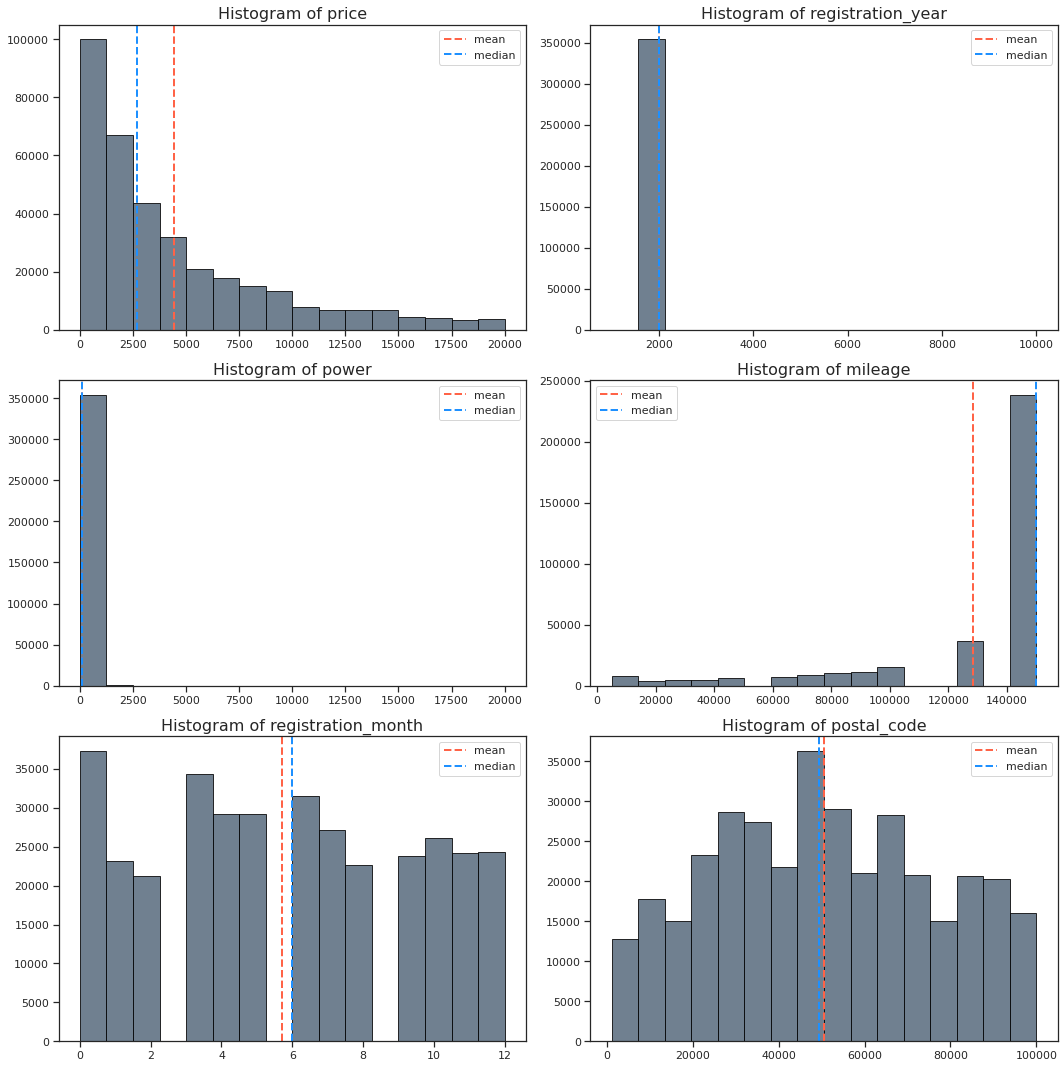

In [12]:
# Graficar histogramas por columna
sns.set(style="ticks")

num_vars = len(numeric_columns)
num_rows = num_vars // 2
num_rows += num_vars % 2 

# Crear sub gráficos
fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows*5)) 

# Aplanar el arreglo de ejes para que podamos iterar sobre él fácilmente
axes = axes.flatten()

# Iterar por cada columna numérica y crear histograma
for i, col in enumerate(numeric_columns):
    axes[i].hist(df[col], bins=16, color='slategray', edgecolor="black", linewidth=0.8)
    
    # Dibujar líneas para media y mediana
    mean_val = df[col].mean()
    median_val = df[col].median()
    mean_line = axes[i].axvline(mean_val, color='tomato', linestyle='dashed', linewidth=2)
    median_line = axes[i].axvline(median_val, color='dodgerblue', linestyle='dashed', linewidth=2)
    
    # Anadir leyenda
    axes[i].legend([mean_line, median_line], ['mean', 'median'])
    axes[i].set_title(f'Histogram of {col}', fontsize=16)
    
# Remover sub gráficos no usados
if len(numeric_columns) % 2:
    for j in range(i+1, num_rows*2):
        fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

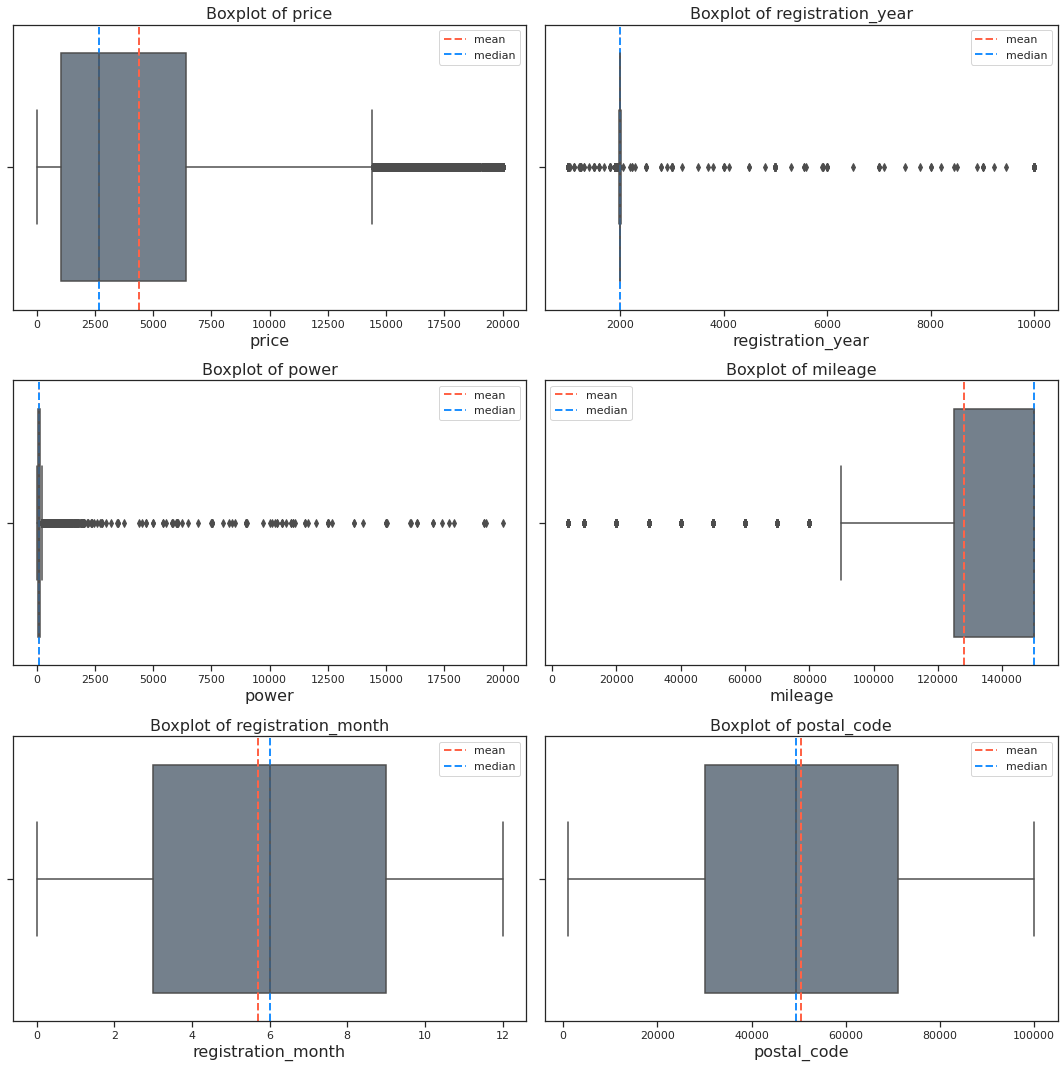

In [13]:
# Graficar boxplots por columna
sns.set(style="ticks")

num_vars = len(numeric_columns)
num_rows = num_vars // 2  # assuming we want 2 plots per row
num_rows += num_vars % 2  # add an extra row if there are leftovers

# Crear sub gráficos
fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows*5))

# Aplanar el arreglo de ejes para que podamos iterar sobre él fácilmente
axes = axes.flatten()

# Iterar por cada columna numérica y crear histograma
for i, col in enumerate(numeric_columns):
    sns.boxplot(x=df[col], color='slategray', ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}', fontsize=20, weight='bold')
    axes[i].set_xlabel(col, fontsize=16)
    
    # Dibujar líneas para media y mediana
    mean_val = df[col].mean()
    median_val = df[col].median()
    mean_line = axes[i].axvline(mean_val, color='tomato', linestyle='dashed', linewidth=2)
    median_line = axes[i].axvline(median_val, color='dodgerblue', linestyle='dashed', linewidth=2)

    # Anadir leyenda
    axes[i].legend([mean_line, median_line], ['mean', 'median'])
    axes[i].set_title(f'Boxplot of {col}', fontsize=16)
    
plt.tight_layout()
plt.show()

Analizando nuestros histogramas, podemos extraer las siguientes primeras conlusiones importantes:

- **Price**: muestra un sesgo hacia la derecha, con mucho valores cercanos a 0 o cero. Algo que deberá revisarse más adelante.


- **Registration Year**: el registro de años de los vehículos se ecuentra muy concentrado.. Como se muestra la mediana y media de estos es casi igual. Por otro lado, como vimos anteriormente, hay valores que son menos a la creación del auto (1836), lo cual no haría mucho sentido.


- **Power**: la media de poder de los vehíuclos registra alrededor de los 100 cvs. Por otro lado, hay valores mayores al auto con mayor cv registrado (Bugatti Bolide - 1,825 CV), estos casos serán tener que revisados y tratados.


- **Milieage**: muestra un sesgo hacia la izquierda, median mayor a la media (128,211.17). Según el histograma no cuenta con valores atípicos que debemos analizar a más detalle.


- **Registration Month**: se registran valores iguales a 0, lo cual puede provenir de usarios que no brindaron dicha información. Esos datos deben tratarse.


Por último ,"Postal Code" no muestran valores atípicos a primera vista.

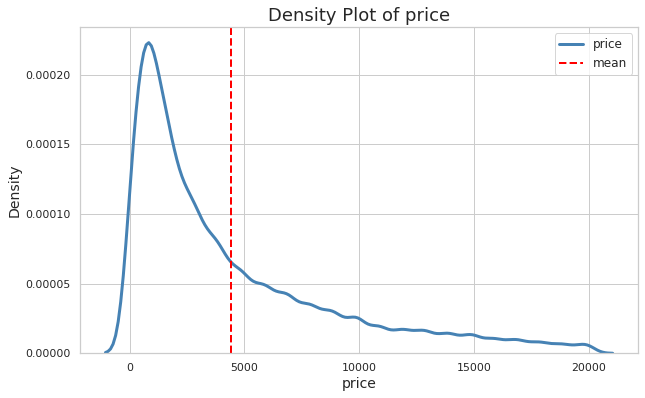

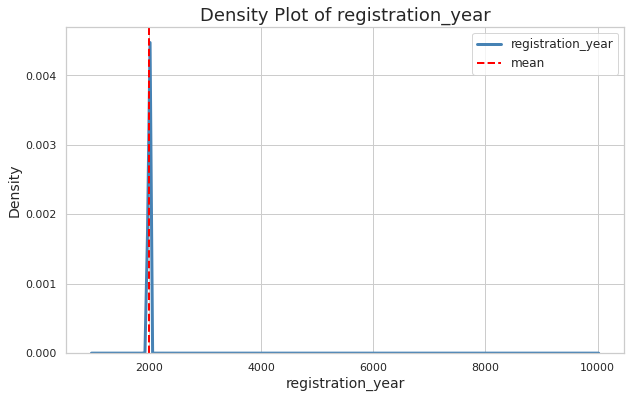

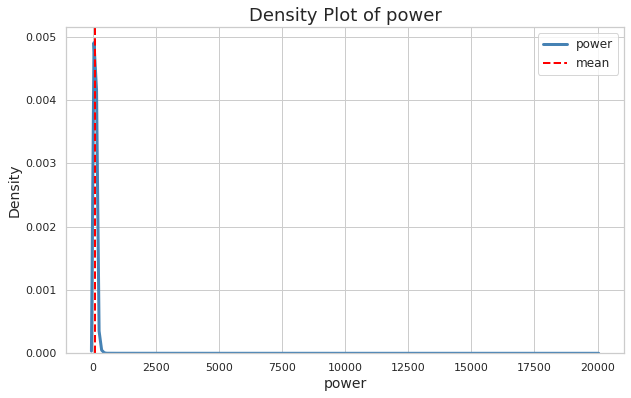

In [14]:
# Graficar gráficso de densidad
sns.set(style="whitegrid")

# Iterar por columnas
columns = ['price', 'registration_year', 'power']
for column in columns:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df[column], color="steelblue", lw=3, label=column)
    
    # Gráficar línea vertical de la media de la distribución
    plt.axvline(df[column].mean(), color='red', linestyle='dashed', linewidth=2, label='mean')
    
    # Incluir leyenda
    plt.legend(loc='upper right', fontsize=12)
    
    # Cambiar tamaño de etiquetas
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.title(f'Density Plot of {column}', fontsize=18)
    plt.show()

Hay una gran cantidad de autos con registros inferiores al año de creación del autos (1886) y superiores al año actual, lo cual no debería suceder. Por otro lado, hay muchos registros con potencia del auto igual a 0, algo que tampoco debería suceder. Por último, la potencia registra valores negativos y concentrados en cero para gran cantidad de resgistros.

### Análisis variables categóricas

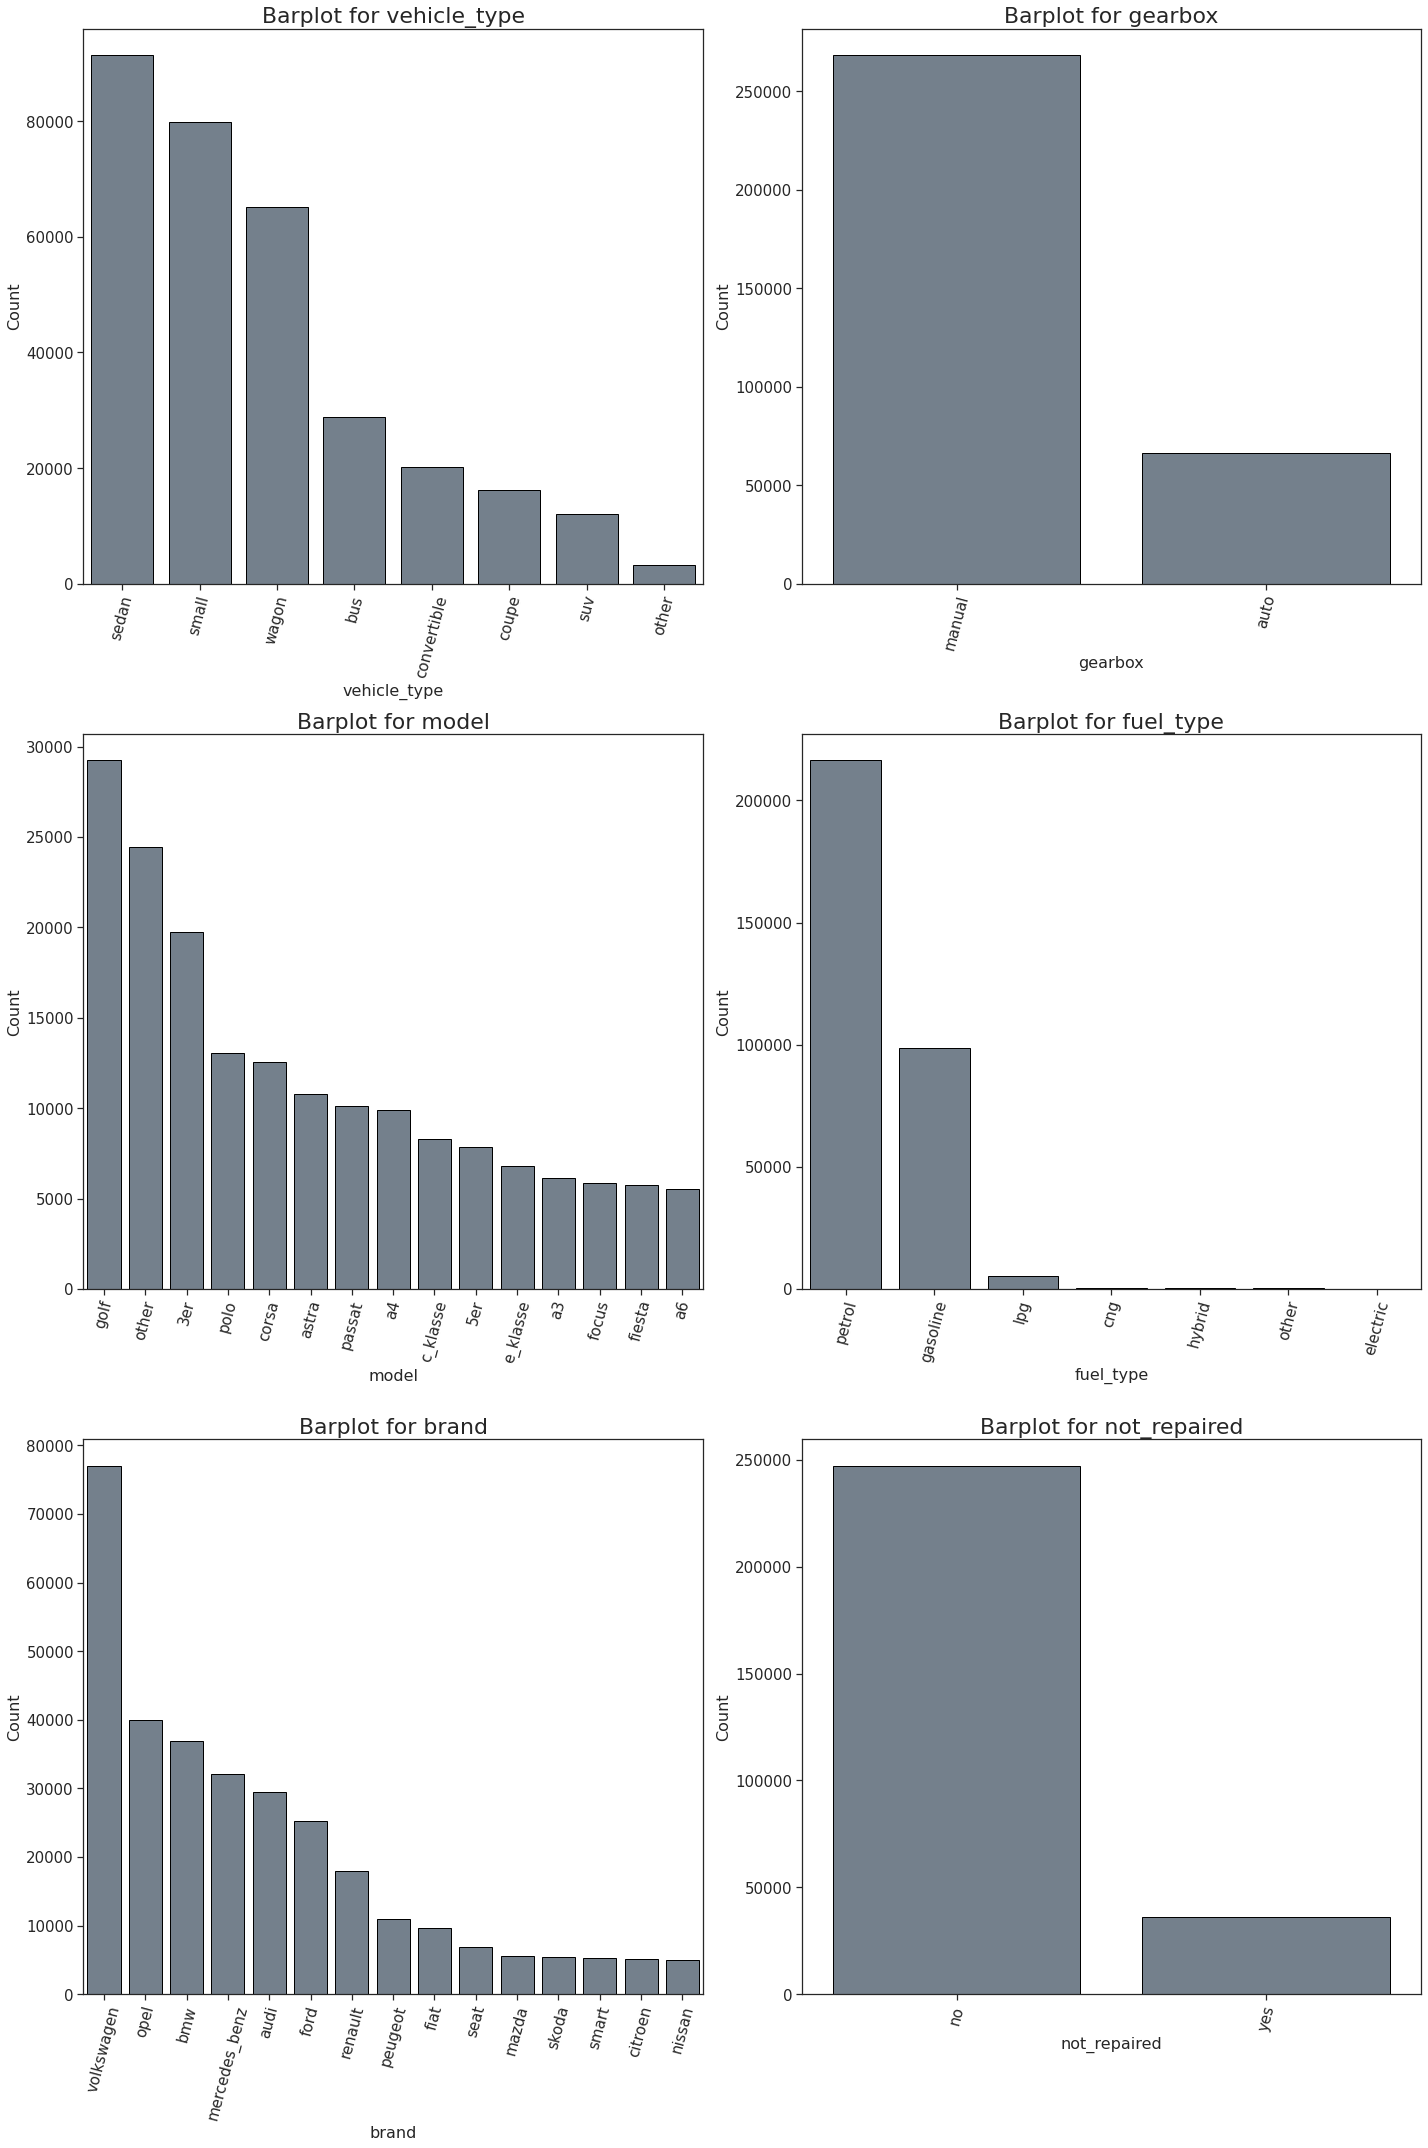

In [15]:
# Establecer el estilo de seaborn
sns.set(style="ticks")

# Determinar el número de filas necesarias para nuestros subgráficos
num_vars = len(categorical_columns)
num_rows = num_vars // 2
num_rows += num_vars % 2

# Crear los subgráficos
fig, axes = plt.subplots(num_rows, 2, figsize=(20, num_rows*10))

# Aplanar el arreglo de ejes para que podamos iterar sobre él fácilmente
axes = axes.flatten()

# Iterar por cada columna
for i, column in enumerate(categorical_columns):
    # Mostrar solamente las primeras 25 categorías para evitar el hacinamiento
    column_order = df[column].value_counts().nlargest(15).index
    sns.countplot(x=column, data=df, order=column_order, ax=axes[i], color="slategray", edgecolor='black')
    axes[i].set_title(f'Barplot for {column}', fontsize=22)
    axes[i].set_xlabel(column, fontsize=16)
    axes[i].set_ylabel('Count', fontsize=16)
    axes[i].tick_params(axis='x', rotation=75, labelsize=15) # rotate the x-axis labels if they're long
    axes[i].tick_params(axis='y', labelsize=15)

plt.tight_layout()
plt.show()

En el caso de las columnas categóricas, podemos concluir lo siguinente:

- **Vehicle Type**: los tipos de vehículos mayor resgistrados son "sedan", "small" y "wagon" correspondientemente.


- **Gearbox**: la mayoría de vehúclos son manuales


- **Model**: el modelo de vehículo mayor registrado corresponde al "golf", seguido de otros no reconocidos y de "3er".


- **Fuel Type**: en cuento al tipo de combustible más usado, la mayor consta de vehículos que usan petróleo y gasolina con gran diferencia en cuanto a otros.

- **Brand**: las marcas mayor registradas son "volkswagen", "opel" y "bwm", siendo "volkswagen" el principal con una diferencia de casi del doble en comparación con "opel" (segundo más registrado).

- **Not Reparired**: la mayorría de los vehículos no han sidop reparados.

Por otro lado, es importante recodar que algunas de esta columnas cuentas con valores nulos lo cuales deben revisarse y tratarse según sea el caso.

Por último, verificaremos la realación entre las variables graficando una matriz de correlación:

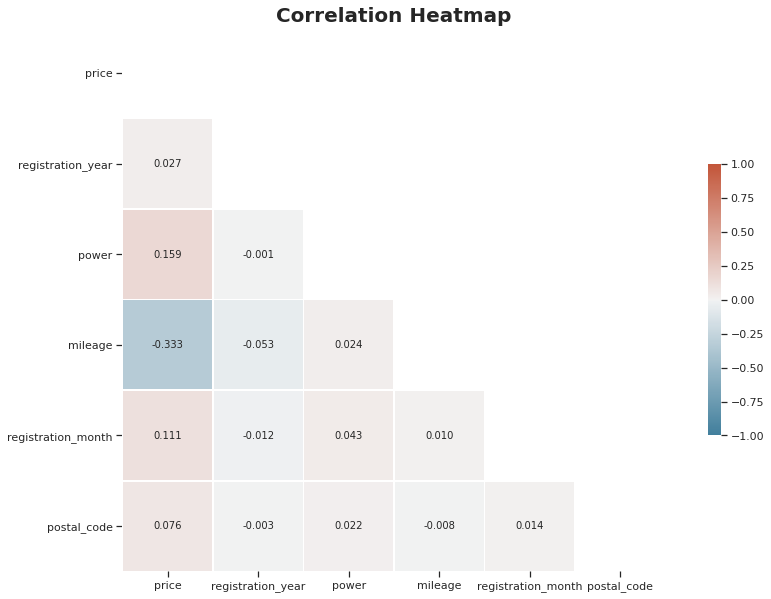

In [16]:
# Calcular la matriz de correlación
corr = df.corr()

# Generar una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar la figura de matplotlib
plt.figure(figsize=(15, 10))

# Generar un mapa de colores divergente personalizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar el mapa de calor con la máscara y la relación de aspecto correcta
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, annot=True, fmt=".3f", annot_kws={'size': 10},
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Añadir un título al mapa de calor
plt.title('Correlation Heatmap', fontsize=20, fontweight='bold')

# Mostrar el mapa de calor
plt.show()

Analizando nuestra matriz podemos inferir lo siguiente:

- La correlación entre el precio del vehículo y poder del mismo es positiva, lo que indica que entre mayor potencia tenga el auto mayor será su precio.
- Se muestra una correlación negativa entre el precio y los kilometros recorridos del auto, los autos con mayor kilometraje tendrán un precio más bajo.
- En cuanto a las otras variables, no se muestra una correlación fuerte entre ellas.

Analizaremos nuevamente la correlación de nuestras variables luego de haber tratado nuestros dataset.

### Conclusiones

1. Se eliminaron los duplicados del dataset y se elimino la columna `number_of_pictures` debido a que solo registraba ceros.
2. Se cambiaron a tipo de dato datime a todas la variables que registran datos de fechas: `date_crawled`, `date_created` y `last_seen`.
3. Las siguientes columnas presentan valores ausentes: `vehicle_type`, `gearbox`, `model`, `fuel_type` y `not_repaired`. Estas deben ser analizadas y tratadas correctamente.
4. En la variable `fuel_type` es necesario que las categorías `petrol` y `gasoline` sean unidas debido a que se trata del mismo tipo de combustible
5. La siguientes columnas presentan valores atípicos, los cuales deben analizarse y tratarse correctamente:
    - `price`: valores iguales a 0.
    - `registration_year`: años de resgitro de 1000 y 9999.
    - `power`: potencias resgitradas de 0 y 20000.
    - `registration_month`: mes de resgitro iguales a 0.

## Preparación de datos

### Valores ausentes

Antes de empezar a analizar y tratar cada variable con valores ausentes, veremos qué porcentaje de valores ausentes cuenta cda una de estas respecto a nuestro dataset:

In [17]:
# Identificar valores ausentes
nan_count = df.isnull().sum()

nan_percent = 100 * nan_count / len(df)

nan_table = pd.concat([nan_count, nan_percent], axis=1)
nan_table.columns = ['Valores Ausentes', '% Ausentes']
nan_table['% Ausentes'] = nan_table['% Ausentes'].apply(lambda x: round(x,2))

# Mostrar solo las columnas que cuentan con valores ausentes
nan_table = nan_table[nan_table['Valores Ausentes'] != 0]

nan_table

,Valores Ausentes,% Ausentes
vehicle_type,37490,10.58
gearbox,19833,5.60
model,19705,5.56
fuel_type,32895,9.28
not_repaired,71154,20.08


La columna con mayor cantidad de ausentes es `not_repaired`, la cual cuenta con alrededor de 20%. En segundo y tercer lugar, se presentan `vehicle_type` con 10.58% y `fuel_type` con 9.28% respectivamente. Finalmente, las columnas `gearbox` y `model` presentan 5.60% y 5.56% de ausentes respectivamente.

#### Valores ausentes `gearbox`

La caja de cambios de los autos está relacionado con el modelo y marca del mismo, por lo cual se procederá a rellenar los valores nulos de utilizando esta información. Crearemos una función donde rellenaremos los valores nulos con los valores de la moda de estas características, es decir con los valores (tipo de caja de cambios) que más se repiten para un modelo y marca relacionada.

En caso no se encuentre el vehículo y marca, usaremos la moda golbal de la caja de cambios.

In [18]:
# Creamos tabla con los valores de la moda que usaremos para reemplazar los valores nulos
gearbox_without_nan = df.dropna(subset=['gearbox', 'model'])

def my_mode(series):
    return mode(series)[0][0]

gearbox_model = gearbox_without_nan.pivot_table(index=['brand', 'model'], values='gearbox', aggfunc=my_mode)
gearbox_model

gearbox
brand      model           
alfa_romeo 145       manual
           147       manual
           156       manual
           159       manual
           other     manual
...                     ...
volvo      v40       manual
           v50       manual
           v60       manual
           v70       manual
           xc_reihe    auto

[297 rows x 1 columns]

In [19]:
# Calcular la moda global de gearbox
gearbox_without_nan_global = df['gearbox'].dropna()
global_mode_gearbox = mode(gearbox_without_nan_global)[0][0]

global_mode_gearbox

'manual'

In [20]:
# Crear función
def fill_gearbox(row):
    model = row['model']
    gearbox = row['gearbox']
    brand = row['brand']
    
    if pd.isna(gearbox):
        try:
            return gearbox_model.loc[(brand, model), 'gearbox']
        except:
            return global_mode_gearbox
    return gearbox

In [21]:
# Comprobar que la función trabaje correctamente
row_values=['volvo', 'xc_reihe', np.nan]
row_columns=['brand', 'model', 'gearbox']
row = pd.Series(data=row_values, index=row_columns)
fill_gearbox(row)

'auto'

In [22]:
# Aplicar la función
df['gearbox'] = df.apply(fill_gearbox, axis = 1)

In [23]:
# Comprobar resultados
df['gearbox'].isnull().sum()

0

#### Valores ausentes `vehicle_type`

En cuanto al tipo del vehículo, este depende de la marca y modelo del mismo. Haremos lo mismo que hicimos, rellenaremos los valores ausentes utilizando las características que dependen del tipo de vehículo.

In [24]:
# Crear tabla con los valores de la moda que usaremos para reemplazar los valores nulos
vehicle_type_without_nan = df.dropna(subset=['vehicle_type', 'model'])

def my_mode(series):
    return mode(series)[0][0]

vehicle_type_model = vehicle_type_without_nan.pivot_table(index=['brand', 'model'], values='vehicle_type', aggfunc=my_mode)
vehicle_type_model

vehicle_type
brand      model                
alfa_romeo 145             small
           147             sedan
           156             wagon
           159             wagon
           other           sedan
...                          ...
volvo      v40             wagon
           v50             wagon
           v60             wagon
           v70             wagon
           xc_reihe          suv

[297 rows x 1 columns]

In [25]:
# Calcular la moda global de vehicle_type
vehicle_type_without_nan_global = df['vehicle_type'].dropna()
global_mode_vehicle_type = mode(vehicle_type_without_nan_global)[0][0]

global_mode_vehicle_type

'sedan'

In [26]:
# Crear función
def fill_vehicle_type(row):
    model = row['model']
    vehicle_type = row['vehicle_type']
    brand = row['brand']
    
    if pd.isna(vehicle_type):
        try:
            return vehicle_type_model.loc[(brand, model), 'vehicle_type']
        except:
            return global_mode_vehicle_type
    return vehicle_type

In [27]:
# Comprobar que la función trabaje correctamente
row_values=['volvo', 'v70', np.nan]
row_columns=['brand', 'model', 'vehicle_type']
row = pd.Series(data=row_values, index=row_columns)
fill_vehicle_type(row)

'wagon'

In [28]:
# Aplicar la función
df['vehicle_type'] = df.apply(fill_vehicle_type, axis = 1)

In [29]:
# Comprobar resultados
df['vehicle_type'].isnull().sum()

0

#### Valores ausentes `fuel_type`

Como se describió anteriormente, "gasoline" y "petrol" se refieren al mismo tipo de combustible. La diferencia se encuentra en que el término "gasoline" es utilizado en Estados Unidos y "petrol" en Reino Unido. Para nuestros fines prácticos, utilizaremos un solo término para nuestros datos.

In [30]:
# Reemplazar petrol por gasoline
df['fuel_type'] = df['fuel_type'].replace('petrol', 'gasoline')

# Comprobar el reemplazo
df['fuel_type'].value_counts(dropna=False, normalize=True)

gasoline    0.889107
NaN         0.092827
lpg         0.014984
cng         0.001594
hybrid      0.000658
other       0.000576
electric    0.000254
Name: fuel_type, dtype: float64

Para los valores ausentes, el tipo de combustible depende del modelo del vehículo. Por lo tanto, procederemos a rellenar los valores ausenten en función del modelo.

In [31]:
# Crear tabla con los valores de la moda que usaremos para reemplazar los valores nulos
fuel_type_without_nan = df.dropna(subset=['fuel_type', 'model'])

def my_mode(series):
    return mode(series)[0][0]

fuel_type_model = fuel_type_without_nan.pivot_table(index=['model'], values='fuel_type', aggfunc=my_mode)
fuel_type_model

,fuel_type
model,
100,gasoline
145,gasoline
147,gasoline
156,gasoline
159,gasoline
...,...
yaris,gasoline
yeti,gasoline
ypsilon,gasoline


In [32]:
# Calcular la moda global de fuel_type
fuel_type_without_nan_global = df['fuel_type'].dropna()
global_mode_fuel_type = mode(fuel_type_without_nan_global)[0][0]

global_mode_fuel_type

'gasoline'

In [33]:
# Crear función
def fill_fuel_type(row):
    model = row['model']
    fuel_type = row['fuel_type']
    
    if pd.isna(fuel_type):
        try:
            return fuel_type_model.loc[(model), 'fuel_type']
        except:
            return global_mode_fuel_type
    return fuel_type

In [34]:
# Comprobar que la función trabaje correctamente
row_values=['yaris', np.nan]
row_columns=['model', 'fuel_type']
row = pd.Series(data=row_values, index=row_columns)
fill_fuel_type(row)

'gasoline'

In [35]:
# Aplicar la función
df['fuel_type'] = df.apply(fill_fuel_type, axis = 1)

In [36]:
# Comprobar resultados
df['fuel_type'].isnull().sum()

0

#### Valores ausentes `model`

El modelo del vehículo depende de la marca y año de lanzamiento, algunos modelos son específicos de algunos años, por ello utilizaremos el año de lanzamiento y marca como referencia. Utilizaremos las mismas técnicas mostradas anteriormente para rellenar los valores ausentes.

In [37]:
# Crear tabla con los valores de la moda que usaremos para reemplazar los valores nulos
model_without_nan = df.dropna(subset=['model'])

def my_mode(series):
    return mode(series)[0][0]

model_brand = model_without_nan.pivot_table(index=['brand', 'registration_year'], values='model', aggfunc=my_mode)
model_brand

model
brand      registration_year       
alfa_romeo 1000                 156
           1234                 156
           1950               other
           1958               other
           1960                 145
...                             ...
volvo      2013                 v60
           2014                 v40
           2016                 v40
           2017                 v40
           2018                 v40

[1887 rows x 1 columns]

In [38]:
# Calcular la moda global de model
model_without_nan_global = df['model'].dropna()
global_mode_model = mode(model_without_nan_global)[0][0]

global_mode_model

'golf'

In [39]:
# Crear función
def fill_model(row):
    registration_year = row['registration_year']
    brand = row['brand']
    model = row['model']
    
    if pd.isna(model):
        try:
            return model_brand.loc[(brand, registration_year), 'model']
        except:
            return global_mode_model
    return model

In [40]:
# Comprobar que la función trabaje correctamente
row_values=['alfa_romeo', 1960, np.nan]
row_columns=['brand', 'registration_year', 'model']
row = pd.Series(data=row_values, index=row_columns)
fill_model(row)

'145'

In [41]:
# Aplicar la función
df['model'] = df.apply(fill_model, axis = 1)

In [42]:
# Comprobar resultados
df['model'].isnull().sum()

0

#### Valores ausentes `not_repaired`

La reparación de cada vehículo solo depende del vendedor, por lo que es difícil relacionar este a alguna otra variables de nuestro dataset. Para este caso, rellenaremos los valores ausentes utlizando todas las variables de nuestro dataset utilizando un modelo que prediga el esta del vehiculo (`not_repaired`).

Empezemos transformando nuestro target `not_repaired` en una variable numérica, donde se establecerá la siguiente relación: **no = 0** y **yes =1**

In [43]:
# Crear diccionario para reemplazar los valores
not_repaired_dict = {'no': 0, 'yes': 1}

# Utilizar la función map para reemplazar los valores
df['not_repaired'] = df['not_repaired'].map(not_repaired_dict)

# Comprobar el reemplazo
df['not_repaired'].value_counts(dropna=False, normalize=True)

0.0    0.697468
NaN    0.200791
1.0    0.101741
Name: not_repaired, dtype: float64

Utilizaremos un modelo de Regresión Logística para predecir si un vehúclo ha sido reparado o no, y con ello rellenaremos los valores ausentes. Primero codifiquemos nuestras características categóricas a trevés de `One-Hot Encoding`.

In [44]:
# Aplicar OHe a nuestro dataset a travpés de la función get_dummies
df_ohe = pd.get_dummies(df, drop_first=True)

# Comprobar la transformación
df_ohe.head()

,date_crawled,price,registration_year,power,mileage,registration_month,not_repaired,date_created,postal_code,last_seen,...,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
0,2016-03-24 11:52:00,480,1993,0,150000,0,NaN,2016-03-24,70435,2016-04-07 03:16:00,...,0,0,0,0,0,0,0,0,1,0
1,2016-03-24 10:58:00,18300,2011,190,125000,5,1.0,2016-03-24,66954,2016-04-07 01:46:00,...,0,0,0,0,0,0,0,0,0,0
2,2016-03-14 12:52:00,9800,2004,163,125000,8,NaN,2016-03-14,90480,2016-04-05 12:47:00,...,0,0,0,0,0,0,0,0,0,0
3,2016-03-17 16:54:00,1500,2001,75,150000,6,0.0,2016-03-17,91074,2016-03-17 17:40:00,...,0,0,0,0,0,0,0,0,1,0
4,2016-03-31 17:25:00,3600,2008,69,90000,7,0.0,2016-03-31,60437,2016-04-06 10:17:00,...,0,1,0,0,0,0,0,0,0,0


Asimismo, para nuestro modelo no utilizaremos las caraterísticas de fecha para predecir nuestros valores ya que no son variables importantes y el formato datetime no funciona en la construcción del modelo.

In [45]:
# Excluir fecha de nuestro dataset
df_ohe = df_ohe.drop(columns=['date_crawled', 'date_created', 'last_seen'])

Ahora que ya tenemos nuestro datset preparado, prodeceremos a desarrollar nuestro modelo.

In [46]:
# Crear un conjunto de datos sin valores ausentes en "not_repaired" y otro con solo los valores ausentes
nan_df_ohe = df_ohe[df_ohe['not_repaired'].isna()]
no_nan_df_ohe = df_ohe[df_ohe['not_repaired'].notna()]

In [47]:
# Determinar features y target del modelo
features = no_nan_df_ohe.drop('not_repaired', axis=1)
target = no_nan_df_ohe['not_repaired']

# Contruir el modelo y lo entrenamos
lr_nan = LogisticRegression(random_state=12345, solver='liblinear')
lr_nan.fit(features, target)

# Determinamos las predicciones
predicted_values = lr_nan.predict(nan_df_ohe.drop('not_repaired', axis=1))

# Reemplazar los valores ausentes en 'not_repaired' con las predicciones
df.loc[df['not_repaired'].isna(), 'not_repaired'] = predicted_values

# Transformar "not_repaired" a tipo entero
df['not_repaired'] = df['not_repaired'].astype('int')

# Comprobar cambios
df['not_repaired'].value_counts(dropna=False, normalize=True)

0    0.898211
1    0.101789
Name: not_repaired, dtype: float64

Finalmente, verificamos que hayamos que ya no hayan valores ausentes en nuestro dataset

In [48]:
# Comprobar reemplazo
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        354369 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             354369 non-null  object        
 5   power               354369 non-null  int64         
 6   model               354369 non-null  object        
 7   mileage             354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           354369 non-null  object        
 10  brand               354369 non-null  object        
 11  not_repaired        354369 non-null  int64         
 12  date_created        354369 non-null  datetime64[ns]
 13  postal_code         354369 no

Ahora comprobaremos nuevamente la cantidad de duplicados y eliminarlos del dataset.

In [49]:
# Verificar la cantidad de duplicados
df.duplicated().sum()

307

In [50]:
# Eliminar datos registros duplicados
df.drop_duplicates(inplace=True)

# Verificar eliminación de duplicados
df.duplicated().sum()

0

### Valores atípicos

Luego de haber tratado los valores ausentes de nuestro dataset, trataremos los valores atípicos. Para esto, analizaremos más a detalle cada columna que contenga valores atípicos y, con ello, estableceremos la mejor manera de tratarlos. Para el análisis, desarrollaremos una función que permita graficar diagramas de caja para cada caso.

In [51]:
# Crear función apra crear boxplot
def boxplot_function(df, column, ylim=None, color="slategray"):
    sns.set_style('whitegrid')
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Establecer propiedad de marcadores outliers
    flierprops = dict(marker='o', markerfacecolor='none', markersize=8, linestyle='none', markeredgecolor='slategray')

    # Usar seaborn para crear gráfico
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, y=column, color=color, orient='v', flierprops=flierprops)

    # Establecer límite del eje y
    if ylim is not None:
        plt.ylim(ylim)

    # Anotar cuartiles, median y potenciales outliers
    plt.axhline(y=(Q1-1.5*IQR), color='tomato', linestyle='solid')
    plt.axhline(y=(Q3+1.5*IQR), color='tomato', linestyle='solid')

    # Andir títulos y etiquetas
    plt.title(f'Boxplot of {column}', fontsize=18, fontweight='bold')
    plt.xlabel('Values', fontsize=14)
    plt.ylabel(column, fontsize=14)

    plt.show()

#### Valores atípicos `registration_year`

Ahora grafiquemos el diagram de caja para `registration_year`, tomando en cuenta las fechas en las que se registraron la mayoría de usuarios.

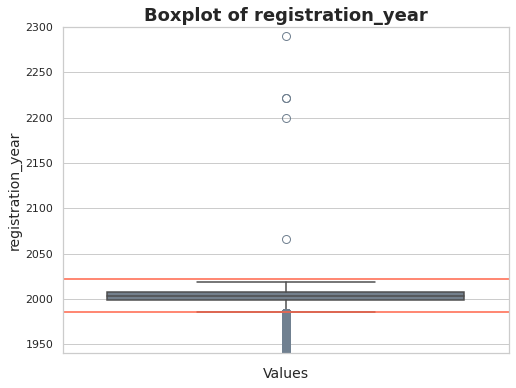

In [52]:
# Graficar diagrama de cajas de 'registration_year'
boxplot_function(df, 'registration_year', (1940, 2300))

Como podemos ver hay años que superan la fecha actual y años que podríar ser menores a la creación del auto (1886). Comparemos las fechas matriculación del auto con las de registros de perfiles. 

In [53]:
print(f'''Fecha más antigua de registro: {df['date_created'].min()}
Fecha más reciente de regsitro: {df['date_created'].max()}
Número de años que abarcan los datos: {df['date_created'].dt.year.max() - df['date_created'].dt.year.min()}''')


Fecha más antigua de registro: 2014-03-10 00:00:00
Fecha más reciente de regsitro: 2016-04-07 00:00:00
Número de años que abarcan los datos: 2


Tomando en cuenta que la fecha de registro de perfiles en la plataforma solo abarca hasta el 2016 y el año de creación del auto fue en 1886, tomaremos solo en cuenta los vehículos matriculados entre 1886 y 2016.

In [54]:
# Filtrar años de registro
df_filtered = df.query('registration_year>=1886 and registration_year<=2016')

# Comprobar filtrado
df_filtered['registration_year'].describe()

count    339467.000000
mean       2002.481929
std           7.091744
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

In [55]:
print(f'Procentaje de valores filtrados: {(len(df) - len(df_filtered))*100/len(df)}')
print(f'Tamaño del nuevo dataset filtrado: {len(df_filtered)}')

Procentaje de valores filtrados: 4.122159395812033
Tamaño del nuevo dataset filtrado: 339467


#### Valores atípicos `price`

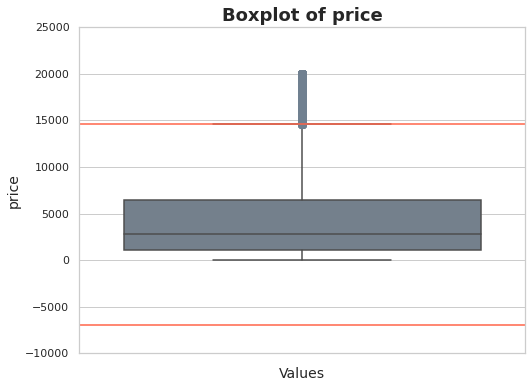

In [56]:
# Graficar diagrama de cajas de 'registration_year'
boxplot_function(df_filtered, 'price', (-10000, 25000))

En cuanto al precio registrado de los vehículos, podemos observar que hay una gran cantidad de valores cercanos a 0 en nuestro dataset. Estos valores son muy extraños para la venta de un vehículo y puede suponer, como ocurre en otras plataformas, que los usarios prefieren no poner precio y que se han contactados por el posible comprador.

Para efectos de nuestro modelo, solo tendremos en cuenta los registros con un precio de venta mayor o igual a los 99 euros.

In [57]:
# Filtrar precio
df_filtered = df_filtered.query('price >= 99')

# Comprobar filtrado
df_filtered['price'].describe()

count    327127.000000
mean       4639.459131
std        4546.087567
min          99.000000
25%        1200.000000
50%        2950.000000
75%        6700.000000
max       20000.000000
Name: price, dtype: float64

In [58]:
print(f'Porcentaje de valores filtrados: {(339512 - len(df_filtered))*100/339512}')

Porcentaje de valores filtrados: 3.6478828436108297


In [59]:
print(f'Porcentaje de valores atípicos filtrados hasta el momento: {(len(df) - len(df_filtered))*100/len(df)}')

Porcentaje de valores atípicos filtrados hasta el momento: 7.607424688331422


#### Valores atípicos `power`

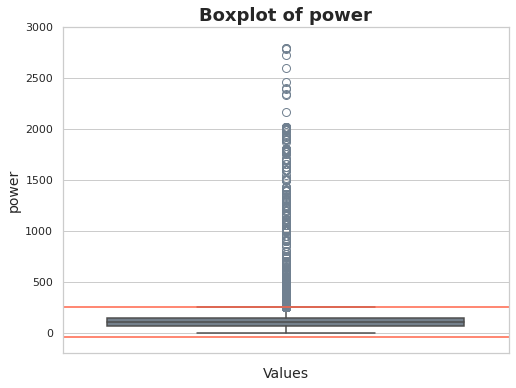

In [60]:
# Graficar diagrama de cajas de 'power'
boxplot_function(df_filtered, 'power', (-200, 3000))

Teniendo en cuenta que la potencia mínima de un auto es de **60cv** y la máxima es de **1800cv**, los valores mostrados en el gráficos muestran valores cercanos a 0 y superiores a 1800cv. Para los casos menos a 60cv, los rellenaremos con `NaN` y buscaremos una forma de reemplazarlos utilizando otras variables. Y para los casos mayores a 2000cv, los consideraremos como atípicos y los filtraremos de nuestro dataset.

In [61]:
# Filtrar power
df_filtered = df_filtered.query('power <= 2000')

# Convertir valores menos a 60cv a 'NaN'
df_filtered.loc[df_filtered['power'] < 60, 'power'] = np.nan

# Comprobar cambios
df_filtered['power'].describe()

count    273680.000000
mean        127.127726
std          62.304352
min          60.000000
25%          90.000000
50%         116.000000
75%         150.000000
max        2000.000000
Name: power, dtype: float64

In [62]:
nan_power = df_filtered[df_filtered['power'].isna()]
print(f'Porcentaje de valores NaN: {nan_power.shape[0]/len(df_filtered)*100}')
print(f'Porcentaje de valores anormales eliminados en total: {(len(df) - len(df_filtered))*100/len(df)}')
print(f'Tamaño del dataset filtrado: {len(df_filtered)}')

Porcentaje de valores NaN: 16.3124644523677
Porcentaje de valores anormales eliminados en total: 7.635950765685106
Tamaño del dataset filtrado: 327026


Tenemos un cantidad significativa de valores `NaN`, rellenaremos estos en función del modelo del vehículo.

In [63]:
# Crear tabla para reemplazar los valores nulos
power_type_without_nan = df_filtered.dropna(subset=['power'])

power_model = power_type_without_nan.pivot_table(index=['model'], values='power', aggfunc='median')
power_model

,power
model,
100,133.0
145,103.0
147,120.0
156,150.0
159,170.0
...,...
yaris,75.0
yeti,110.0
ypsilon,60.0


In [64]:
# Crear función
def fill_power(row):
    model = row['model']
    power = row['power']
    
    if pd.isna(power):
        try:
            return power_model.loc[model, 'power']
        except:
            return np.nan
    return power

In [65]:
# Comprobar que la función trabaje correctamente
row_values=['ypsilon', np.nan]
row_columns=['model', 'power']
row = pd.Series(data=row_values, index=row_columns)
fill_power(row)

60.0

In [66]:
# Aplicar la función
df_filtered['power'] = df_filtered.apply(fill_power, axis = 1)

In [67]:
# Comprobar resultados
df_filtered['power'].isnull().sum()

396

In [68]:
nan_power = df_filtered[df_filtered['power'].isna()]
print(f'Porcentaje de valores NaN: {nan_power.shape[0]/len(df_filtered)*100}')
print(f'Porcentaje de valores anormales eliminados en total: {(len(df) - len(df_filtered))*100/len(df)}')
print(f'Tamaño del dataset filtrado: {len(df_filtered)}')

Porcentaje de valores NaN: 0.121091289377603
Porcentaje de valores anormales eliminados en total: 7.635950765685106
Tamaño del dataset filtrado: 327026


Como hemos corroborado, no hemos podido rellenar todos los valores `NaN` utilizando el modelo de vehículo. Ahora utilizaremos el tipo de vehículo para rellenar estos valores restantes.

In [69]:
# Crear tabla que usaremos para reemplazar los valores nulos
power_type_without_nan = df_filtered.dropna(subset=['power'])

power_model_vehicle_type = power_type_without_nan.pivot_table(index=['vehicle_type'], values='power', aggfunc='median')
power_model_vehicle_type

,power
vehicle_type,
bus,116.0
convertible,125.0
coupe,150.0
other,102.0
sedan,120.0
small,75.0
suv,150.0
wagon,136.0


In [70]:
# Crear función
def fill_power_vehicle_type(row):
    vehicle_type = row['vehicle_type']
    power = row['power']
    
    if pd.isna(power):
        try:
            return power_model_vehicle_type.loc[vehicle_type, 'power']
        except:
            return np.nan
    return power

In [71]:
# Comprobar que la función trabaje correctamente
row_values=['sedan', np.nan]
row_columns=['vehicle_type', 'power']
row = pd.Series(data=row_values, index=row_columns)
fill_power_vehicle_type(row)

120.0

In [72]:
# Aplicar la función
df_filtered['power'] = df_filtered.apply(fill_power_vehicle_type, axis = 1)

In [73]:
# Comprobar resultados
df_filtered['power'].isnull().sum()

0

In [74]:
nan_power = df_filtered[df_filtered['power'].isna()]
print(f'Porcentaje de valores NaN: {nan_power.shape[0]/len(df_filtered)*100}')
print(f'Porcentaje de valores anormales eliminados en total: {(len(df) - len(df_filtered))*100/len(df)}')
print(f'Tamaño del dataset filtrado: {len(df_filtered)}')

Porcentaje de valores NaN: 0.0
Porcentaje de valores anormales eliminados en total: 7.635950765685106
Tamaño del dataset filtrado: 327026


In [75]:
print(f'Porcentaje de valores filtrados: {(339512 - len(df_filtered))*100/339512}')

Porcentaje de valores filtrados: 3.6776314239261056


In [76]:
print(f'Porcentaje de valores atípicos filtrados hasta el momento: {(len(df) - len(df_filtered))*100/len(df)}')

Porcentaje de valores atípicos filtrados hasta el momento: 7.635950765685106


#### Valores atípicos `registration_month`

Como vimos anteriormente, `registration_month` cuenta con muchos registros iguales a 0. Esto puedo ocurrir debido a que usarios no colocaron datos en este campo. Trataremos estos valores reemplazandolos por la mediana de la columna.

In [77]:
# Verificar valores en registration_month
df_filtered['registration_month'].value_counts(normalize=True)

3     0.099494
6     0.090525
0     0.086424
4     0.084137
5     0.083813
7     0.078468
10    0.075548
11    0.070025
12    0.069701
9     0.069016
1     0.066560
8     0.065032
2     0.061258
Name: registration_month, dtype: float64

In [78]:
# Reemplazar los valores 0 con la mediana de la columna
df_filtered['registration_month'] = (df_filtered['registration_month'].replace(
    0, df_filtered['registration_month'].median())).astype('int')

# Comprobar resultados
df_filtered['registration_month'].value_counts(normalize=True)

6     0.176949
3     0.099494
4     0.084137
5     0.083813
7     0.078468
10    0.075548
11    0.070025
12    0.069701
9     0.069016
1     0.066560
8     0.065032
2     0.061258
Name: registration_month, dtype: float64

**Cálculo de edad del vehículo**

Por último añadiremos una columna adiccional a nuestro dataset que nos servirá para nuestro modelo. Esta columna será `car_age`, la diferencia entre la fecha en que se creo el perfil del usuarios y el años de matriculación del vehículo.

In [79]:
# Calcular "car_age"
df_filtered['car_age'] = df_filtered['date_created'].dt.year - df_filtered['registration_year']

# Comporbar valores de "car_age"
df_filtered['car_age'].describe()

count    327026.000000
mean         13.376796
std           6.864564
min           0.000000
25%           9.000000
50%          13.000000
75%          17.000000
max         106.000000
Name: car_age, dtype: float64

**Datset Final**

Por último, filtramos nuestro dataset para obtener solo con las columnas que usaremos en nuestro modelo. En este caso, filtraremos las columnas referidas a fechas, código postal, mes de registro del vehículo y fecha de matriculación del vehículo (esta se hará referencia en el modelo con la columna `car_age`).

In [80]:
# Obtener dataset final
columnas = ['date_crawled', 'registration_year', 'registration_month', 'date_created', 'postal_code', 'last_seen']
df_final = df_filtered.drop(columnas, axis=1)
df_final.head()

,price,vehicle_type,gearbox,power,model,mileage,fuel_type,brand,not_repaired,car_age
0,480,sedan,manual,101.0,golf,150000,gasoline,volkswagen,0,23
1,18300,coupe,manual,190.0,a4,125000,gasoline,audi,1,5
2,9800,suv,auto,163.0,grand,125000,gasoline,jeep,0,12
3,1500,small,manual,75.0,golf,150000,gasoline,volkswagen,0,15
4,3600,small,manual,69.0,fabia,90000,gasoline,skoda,0,8


In [81]:
# Ver datos estadísticos
df_final.describe()

,price,power,mileage,not_repaired,car_age
count,327026.000000,327026.000000,327026.000000,327026.000000,327026.000000
mean,4639.752610,122.181527,128360.069230,0.099139,13.376796
std,4546.285188,59.623588,37258.435014,0.298849,6.864564
min,99.000000,60.000000,5000.000000,0.000000,0.000000
25%,1200.000000,80.000000,125000.000000,0.000000,9.000000
50%,2950.000000,111.000000,150000.000000,0.000000,13.000000
75%,6700.000000,145.000000,150000.000000,0.000000,17.000000
max,20000.000000,2000.000000,150000.000000,1.000000,106.000000


In [82]:
# Verificar contenido
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327026 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         327026 non-null  int64  
 1   vehicle_type  327026 non-null  object 
 2   gearbox       327026 non-null  object 
 3   power         327026 non-null  float64
 4   model         327026 non-null  object 
 5   mileage       327026 non-null  int64  
 6   fuel_type     327026 non-null  object 
 7   brand         327026 non-null  object 
 8   not_repaired  327026 non-null  int64  
 9   car_age       327026 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 27.4+ MB


**Análisis de correlación**

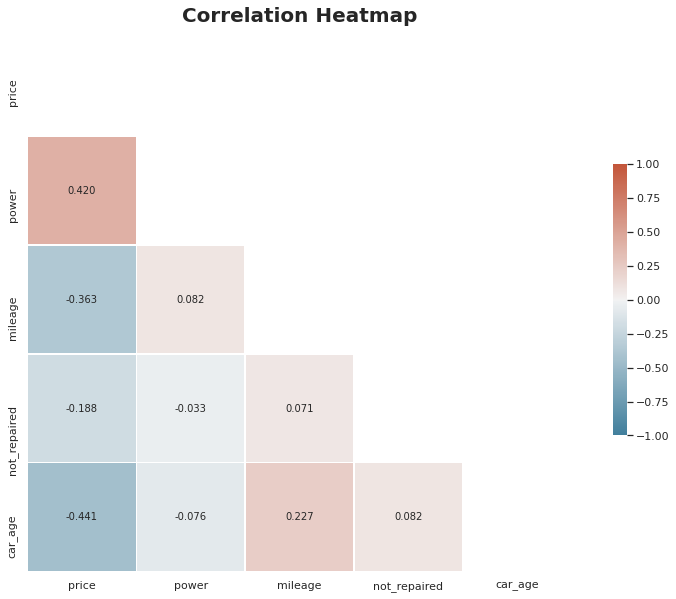

In [83]:
# Calcular la matriz de correlación
corr = df_final.corr()

# Generar una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar la figura de matplotlib
plt.figure(figsize=(15, 10))

# Generar un mapa de colores divergente personalizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar el mapa de calor con la máscara y la relación de aspecto correcta
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, annot=True, fmt=".3f", annot_kws={'size': 10},
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Añadir un título al mapa de calor
plt.title('Correlation Heatmap', fontsize=20, fontweight='bold')

# Mostrar el mapa de calor
plt.show()

Analizando nuestra matriz podemos concluir lo siguiente:

- La correlación entre el precio del vehículo y poder del mismo sigue siendo importante: mayor potencia, a mayor precio se oferta.
- Se muestra una correlación negativa entre el precio y los kilometros recorridos del auto se sigue manteniendo, los autos con mayor kilometraje registran un precio más bajo.
- Los años del vehículo impacta significativamente en el precio, los vehículos con más años registran menor precio.
- Los vehículos reparados tienden a tener un menor precio.

## Entrenamiento del modelo

Luego de haber tratado los valores ausentes y atípicos de nuestro dataset, es momento de construir varios modelos de ML para cumplir con el objetivo de la compañía: determinar el valor de mercado de un vehículo. Para la construcción de modelos. compararemos modelos de regresión lineal, arból de decisión y bosque aletorio con métodos de potenciación de gradiente: `LightGBM`, `CatBoost` y `XGBoost`.

En nuestro dataset final, las caraterísticas `brand` y `model` cuentan con 40 y 250 categorías únicas respectivamente, por ello será necesario codifcar esta características para cada modelo, ya que se tratarían de variables de alta cardinalidad. `One-Hot Enconding` será útilizado para regresión lineal, sin embargo no lo será para los modelos de árboles ya que procesan una función a la vez. Por lo que para los modelo de árboles, utilizaremos la codificación de etiquetas.

Por último, mediremos la velocidad de entrenamiento y preddición de cada modelo, y la calidad será medida través del `RECM`.

In [84]:
print(f'Número de categorías de marca: {len(df_final["brand"].unique())}')
print(f'Número de categorías de modelo: {len(df_final["model"].unique())}')

Número de categorías de marca: 40
Número de categorías de modelo: 250


### Regresión Lineal

Como especificamos anetiormente, para regresión lineal la codificación **OHE** es la mejor técnica, se codifican las categorías asignándoles la misma importancia a todas, pero sin perder sus diferencias. A su vez, estandarizaremos las características numerícas utilizando **StandarScaler**. Usaremos la regresión lineal como nuestra prueba de cordura, buscando que los métodos de potenciación de gradiente presenten una mejor calidad.

In [85]:
# Codificar las características categóricas
df_ohe = pd.get_dummies(df_final, drop_first=True)

# Establecer las variables numerícas
numeric_ohe = ['power', 'mileage', 'car_age']

#Escalar los datos numéricos
scaler = StandardScaler()
scaler.fit(df_ohe[numeric_ohe])
df_ohe[numeric_ohe] = scaler.transform(df_ohe[numeric_ohe])
df_ohe.head()

,price,power,mileage,not_repaired,car_age,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,...,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
0,480,-0.355255,0.580807,0,1.401869,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,18300,1.137445,-0.090183,1,-1.220297,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9800,0.684604,-0.090183,0,-0.200566,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500,-0.791324,0.580807,0,0.236462,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,3600,-0.891956,-1.029569,0,-0.783270,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


In [86]:
# Determinarfeatures y target del modelo
features_ohe = df_ohe.drop('price', axis=1)
target_ohe = df_ohe['price']

# Dividir nuestro dataset en conjunto de entrenamiento y prueba 75:25
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
    features_ohe, 
    target_ohe,
    test_size=0.25,
    random_state=12345
)

# Comprobar división
print(f'Tamaño del conjunto de entrenamiento OHE: {features_train_ohe.shape}, {target_train_ohe.shape}')
print(f'Tamaño del conjunto de prueba OHE: {features_test_ohe.shape}, {target_test_ohe.shape}')

Tamaño del conjunto de entrenamiento OHE: (245269, 305), (245269,)
Tamaño del conjunto de prueba OHE: (81757, 305), (81757,)


In [87]:
# Entrenar el modelo de regresión lineal
start_train = time.time()
lr_model = LinearRegression()
lr_model.fit(features_train_ohe, target_train_ohe)
end_train= time.time()

# Realizar predicciones
start_test = time.time()
target_pred = lr_model.predict(features_test_ohe)
end_test = time.time()

# Establecer las métricas de tiempo y calidad
RECM_lr = mean_squared_error(target_test_ohe, target_pred)**0.5
print(f'RECM de modelo de Regresión Lineal: {RECM_lr:.3f}')
print(f'Tiempo de entrenamiento del modelo: {end_train - start_train:.3f}s')
print(f'Tiempo de prueba del modelo: {end_test - start_test:.3f}s')

RECM de modelo de Regresión Lineal: 2858.902
Tiempo de entrenamiento del modelo: 19.837s
Tiempo de prueba del modelo: 0.211s


El modelo de Regresión Lineal obtuvo un RECM de 2855, este será nuestra prueba de cordura y servirá como valor base para comparar con otro modelos y método de potenciación gradiente. El tiempo de entrenamiento fue de ≈ 23s y el tiempo para realizar la predicción fue de ≈13s.

Si un modelo de potenciación de gradiente funciona obtiene un RECM mayor 2855 algo habrá salido mal. 

### Árbol de Decisión

Para el árbol de decisión, usaremos la codificación de etiquetas debido a que contamos con características de alta cardinalidad como lo vimos anteriormente. El uso de OHE en variables con un gran número de categrorías disminuye la eficiencia de modelos basados en árboles, es por eso que no utilizaremos esta técnica.

Asimimso, utilizaremos `GridSearchCv` para encontrar los mejores hiperparámetros.

In [88]:
# Crear un copia de nuestro datset final
df_ordinal = df_final.copy().reset_index(drop=True)

# Establecer las características categóricas
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']

# Codificar las características categóricas
encoder = OrdinalEncoder()
encoder.fit(df_final[cat_features])
df_ordinal[cat_features] = pd.DataFrame(encoder.transform(df_final[cat_features]), columns=cat_features)
df_ordinal

,price,vehicle_type,gearbox,power,model,mileage,fuel_type,brand,not_repaired,car_age
0,480,4.0,1.0,101.0,116.0,150000,2.0,38.0,0,23
1,18300,2.0,1.0,190.0,29.0,125000,2.0,1.0,1,5
2,9800,6.0,0.0,163.0,117.0,125000,2.0,14.0,0,12
3,1500,5.0,1.0,75.0,116.0,150000,2.0,38.0,0,15
4,3600,5.0,1.0,69.0,101.0,90000,2.0,31.0,0,8
...,...,...,...,...,...,...,...,...,...,...
327021,1150,0.0,1.0,125.0,249.0,150000,2.0,24.0,0,16
327022,2200,4.0,1.0,101.0,116.0,20000,2.0,33.0,0,11
327023,1199,1.0,0.0,101.0,106.0,125000,2.0,32.0,0,16
327024,9200,0.0,1.0,102.0,224.0,150000,2.0,38.0,0,20


In [89]:
# Determinar features y target del modelo
features_ordinal = df_ordinal.drop('price', axis=1)
target_ordinal = df_ordinal['price']

# Dividir nuestro dataset en conjunto de entrenamiento y prueba 75:25
features_train_ordinal, features_test_ordinal, target_train_ordinal, target_test_ordinal = train_test_split(
    features_ordinal, 
    target_ordinal,
    test_size=0.25,
    random_state=12345
)

# Comprobar división
print(f'Tamaño del conjunto de entrenamiento ordinal: {features_train_ordinal.shape}, {target_train_ordinal.shape}')
print(f'Tamaño del conjunto de prueba ordinal: {features_test_ordinal.shape}, {target_test_ordinal.shape}')

Tamaño del conjunto de entrenamiento ordinal: (245269, 9), (245269,)
Tamaño del conjunto de prueba ordinal: (81757, 9), (81757,)


**Ajuste de Hiperparámetros**

In [90]:
# Establecer los hiperparámetros de árbol de decisión
params_dt = {
    'max_depth': [1, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [2, 4, 6, 8]
}

# Usar la función GridSearchCV y pasamos los hiperparámetros establecidos, la métrica y el valor para la validación cruzada
gridSearch_dt = GridSearchCV(
    estimator=DecisionTreeRegressor(),
    param_grid=params_dt,
    scoring='neg_root_mean_squared_error',
    cv=3
)

In [ ]:
# Entrenar nuestro modelo para encontrar los mejores hiperparámetros
start = time.time()
gridSearch_dt.fit(features_train_ordinal, target_train_ordinal)
end = time.time()
print(f'Tiempo de ajuste de hiperparámetros de Árbol de Decisión: {end - start:.3f}s')

In [ ]:
# Encontrar los mejores hiperparámetros
best_index = np.argmax(gridSearch_dt.cv_results_['mean_test_score'])
best_set_of_params = gridSearch_dt.cv_results_['params'][best_index]
best_score = gridSearch_dt.cv_results_['mean_test_score'][best_index]

print(f'Mejores hiperparámetros: {best_set_of_params} | Mejor RECM: {-best_score:.3f}')

**Entrenamiento de Modelo**

In [ ]:
# Entrenar el modelo de árbol de decisión
start_train = time.time()
dt_model = DecisionTreeRegressor(random_state=12345, max_depth=6, min_samples_split=2, min_samples_leaf=2)
dt_model.fit(features_train_ordinal, target_train_ordinal)
end_train= time.time()

# Realizamos predicciones
start_test = time.time()
target_pred_dt = dt_model.predict(features_test_ordinal)
end_test = time.time()

# Establecemos las metrícas de tiempo y calidad
RECM_dt = mean_squared_error(target_test_ordinal, target_pred_dt, squared=False)
print(f'RECM de modelo de Árbol de Decisión: {RECM_dt:.3f}')
print(f'Tiempo de entrenamiento del modelo: {end_train - start_train:.3f}s')
print(f'Tiempo de prueba del modelo: {end_test - start_test:.3f}s')

Los mejores hiperparámetros para el modelo de Árbol de decisión son {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2} obteniendo un RECM de 2325 con un tiempo de entrenamiento de ≈0.43s y de predicción de ≈0.009s.

### Bosque Aleatorio

Al igual que en el modelo de árbol de decisión, utilizaremos lo datos con codificación oridnal para nuestro modelo de bosque aleatorio.

**Ajuste de Hiperparámetros**

In [ ]:
# Establecer los hiperparámetros de árbol de decisión
params_rf = {
    'n_estimators': [10, 20, 40],
    'max_depth': [1, 2, 3, 4, 5, 6]
}

# Usar la función GridSearchCV y pasamos los hiperparámetros establecidos, la métrica y el valor para la validación cruzada
gridSearch_rf = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=params_rf,
    scoring='neg_root_mean_squared_error',
    cv=3
)

In [ ]:
# Entrenar nuestro modelo para encontrar los mejores hiperparámetros
start = time.time()
gridSearch_rf.fit(features_train_ordinal, target_train_ordinal)
end = time.time()
print(f'Tiempo de ajuste de hiperparámetros de Árbol de Decisión: {end - start:.3f}s')

In [ ]:
# Encontrar los mejores hiperparámetros
best_index = np.argmax(gridSearch_rf.cv_results_['mean_test_score'])
best_set_of_params = gridSearch_rf.cv_results_['params'][best_index]
best_score = gridSearch_rf.cv_results_['mean_test_score'][best_index]

print(f'Mejores hiperparámetros: {best_set_of_params} | Mejor RECM: {-best_score:.3f}')

**Entrenamiento de Modelo**

In [ ]:
# Entrenar el modelo de bosque aleatorio
start_train = time.time()
rf_model = RandomForestRegressor(random_state=12345, max_depth=6, n_estimators=40)
rf_model.fit(features_train_ordinal, target_train_ordinal)
end_train= time.time()

# Realizamos predicciones
start_test = time.time()
target_pred_rf = rf_model.predict(features_test_ordinal)
end_test = time.time()

# Establecemos las metrícas de tiempo y calidad
RECM_rf = mean_squared_error(target_test_ordinal, target_pred_rf, squared=False)
print(f'RECM de modelo de Bosque Aleatorio: {RECM_rf:.3f}')
print(f'Tiempo de entrenamiento del modelo: {end_train - start_train:.3f}s')
print(f'Tiempo de prueba del modelo: {end_test - start_test:.3f}s')

Para el modelo de Bosque Aleatorio los mejores hiperparámetros son {'max_depth': 6, 'n_estimators': 40} obteniendo un RECM de 2279 con un tiempo de entrenamiento de ≈14s y de predicción de ≈0.25s.

### CatBoost

CatBoost es un métodode potenciación de gradiente que no necesita de un preprocesamiento de catracterícticas categóricas, por lo que no es necesario utilizar OHE o codificación de etiquetas ya que el propio método asigna etiquetas. Es por ello que trabajaremos con nuestro dataset final `df_final`.

In [ ]:
# Determinar features y target del modelo
features = df_final.drop('price', axis=1)
target = df_final['price']

# Dividir nuestro dataset en conjunto de entrenamiento y prueba 75:25
features_train, features_test, target_train, target_test = train_test_split(
    features, 
    target,
    test_size=0.25,
    random_state=12345
)

# Comprobar división
print(f'Tamaño del conjunto de entrenamiento ordinal: {features_train.shape}, {target_train.shape}')
print(f'Tamaño del conjunto de prueba ordinal: {features_test.shape}, {target_test.shape}')

**Ajuste de Hiperparámetros**

In [ ]:
# Establecer las características categóricas
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']

# Establecer los hiperparámetros que vamos a ajustar
params_catboost = {
    'depth': [4, 6, 10],
    'learning_rate': [0.1, 0.2, 0.5]
}

# Llamar al estimador que utilizaremos, CatBoostRegressor y lo pasamos a GridSearchCv
catboost_est = CatBoostRegressor(iterations=100, cat_features=cat_features, verbose=False, loss_function='RMSE')

# Usar la función GridSearchCV y pasamos los hiperparámetros establecidos, la métrica y el valor para la validación cruzada
gridSearch_catboost = GridSearchCV(
    estimator=catboost_est,
    param_grid=params_catboost,
    scoring='neg_root_mean_squared_error',
    cv=3
)

In [ ]:
# Entrenar nuestro modelo para encontrar los mejores hiperparámetros
start = time.time()
gridSearch_catboost.fit(features_train, target_train)
end = time.time()
print(f'Tiempo de ajuste de hiperparámetros de CatBoost: {end - start:.3f}s')

In [ ]:
# Encontrar los mejores hiperparámetros
best_index = np.argmax(gridSearch_catboost.cv_results_['mean_test_score'])
best_set_of_params = gridSearch_catboost.cv_results_['params'][best_index]
best_score = gridSearch_catboost.cv_results_['mean_test_score'][best_index]

print(f'Mejores hiperparámetros: {best_set_of_params} | Mejor RECM: {-best_score:.3f}')

**Entrenamiento de Modelo**

In [ ]:
# Entrenar el modelo de catboost
catboost_model = CatBoostRegressor(
    iterations=100,
    depth=10,
    learning_rate=0.5,
    loss_function='RMSE',
    random_seed=12345
)

start_train = time.time()
catboost_model.fit(features_train, target_train, cat_features=cat_features, verbose=False)
end_train= time.time()

# Realizar predicciones
start_test = time.time()
target_pred_cat = catboost_model.predict(features_test)
end_test = time.time()

# Establecer las metrícas de tiempo y calidad
RECM_cat = mean_squared_error(target_test, target_pred_cat, squared=False)
print(f'RECM de modelo de CatBoost: {RECM_cat:.3f}')
print(f'Tiempo de entrenamiento del modelo: {end_train - start_train:.3f}s')
print(f'Tiempo de prueba del modelo: {end_test - start_test:.3f}s')

CatBoost obtuvo un RECM de 1643 urilizando los hiperparámetros {'depth': 10, 'learning_rate': 0.5} con un tiempo de entrenamiento de ≈30s y de predicción de ≈0.18s.

### LightGBM

Al igual que CatBoost puede procesar características categóricas. Sin embargo, es necesario transformar previamente las caraterísticas a tipo entero ya que no acepta variables tipo string u objeto, también se pude cambiar las características a tipo "category", que es lo que haremos a continuación.

In [ ]:
# Transformar caraterísticas categóricas a tipo "category"
for feature in cat_features:
    df_final[feature] = df_final[feature].astype("category")
    
# Determinar features y target del modelo
features_gbm = df_final.drop('price', axis=1)
target_gbm = df_final['price']

# Dividir nuestro dataset en conjunto de entrenamiento y prueba 75:25
features_train_gbm, features_test_gbm, target_train_gbm, target_test_gbm = train_test_split(
    features_gbm, 
    target_gbm,
    test_size=0.25,
    random_state=12345
)

# Comprobar división
print(f'Tamaño del conjunto de entrenamiento ordinal: {features_train_gbm.shape}, {target_train_gbm.shape}')
print(f'Tamaño del conjunto de prueba ordinal: {features_test_gbm.shape}, {target_test_gbm.shape}')

**Ajuste de Hiperparámetros**

In [ ]:
# Establecer los hiperparámetros que vamos a ajustar
params_lightgbm = {
    'n_estimators': [100, 300],
    'learning_rate': [0.1, 0.2, 0.5],
    'num_leaves': [10, 20]
}

# Llamar al estimador que utilizaremos
lightgbm_est = LGBMRegressor()

# Usar la función GridSearchCV y pasamos los hiperparámetros establecidos, la métrica y el valor para la validación cruzada
gridSearch_lightgbm = GridSearchCV(
    estimator=lightgbm_est,
    param_grid=params_lightgbm,
    scoring='neg_root_mean_squared_error',
    cv=3
)

In [ ]:
# Entrenar nuestro modelo para encontrar los mejores hiperparámetros
start = time.time()
gridSearch_lightgbm.fit(features_train_gbm, target_train_gbm)
end = time.time()
print(f'Tiempo de ajuste de hiperparámetros de LightGBM: {end - start:.3f}s')

In [ ]:
# Encontrar los mejores hiperparámetros
best_index = np.argmax(gridSearch_lightgbm.cv_results_['mean_test_score'])
best_set_of_params = gridSearch_lightgbm.cv_results_['params'][best_index]
best_score = gridSearch_lightgbm.cv_results_['mean_test_score'][best_index]

print(f'Mejores hiperparámetros: {best_set_of_params} | Mejor RECM: {-best_score:.3f}')

**Entrenamiento de Modelo**

In [ ]:
# Entrenar el modelo de LightGBM
lightgbm_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.2,
    num_leaves=20,
    random_seed=12345
)

start_train = time.time()
lightgbm_model.fit(features_train_gbm, target_train_gbm)
end_train= time.time()

# Realizar predicciones
start_test = time.time()
target_pred_gbm = lightgbm_model.predict(features_test_gbm)
end_test = time.time()

# Establecer las metrícas de tiempo y calidad
RECM_light = mean_squared_error(target_test_gbm, target_pred_gbm, squared=False)
print(f'RECM de modelo de LightGBM: {RECM_light:.3f}')
print(f'Tiempo de entrenamiento del modelo: {end_train - start_train:.3f}s')
print(f'Tiempo de prueba del modelo: {end_test - start_test:.3f}s')

En el caso de LightGBM, los mejores hiperparámetros son {'learning_rate': 0.2, 'n_estimators': 300, 'num_leaves': 20} con un RECM de 1619, y con un tiempo de entrenamiento de ≈8.6s y de predicción de ≈1.89s.

### XGBoost

XGBoost, a diferencia de LightGBM y CatBoost, no tiene su propia implementación para tratar variables cataegóricas, solo acepta numéricas. Por que lo es necesario preprocesar las características categróricas previo a construir el modelo a través de `One-Hot Enconding`.

Para ello, utilizaremos el conjunto de entrenamiento y prueba que se usaron en el modelo de regresión lineal `features_train_ohe`, `features_test_ohe`.

**Ajuste de Hiperparámetros**

In [ ]:
# Establecer los hiperparámetros que vamos a ajustar
params_xboost = {
    'max_depth': [4, 6, 8],
    'n_estimators': [50, 100]
}

# Llamar al estimador que utilizaremos
xboost_est = XGBRegressor()

# Usar la función GridSearchCV y pasamos los hiperparámetros establecidos, la métrica y el valor para la validación cruzada
gridSearch_xboost = GridSearchCV(
    estimator=xboost_est,
    param_grid=params_xboost,
    scoring='neg_root_mean_squared_error',
    cv=3
)

In [ ]:
# Entrenar nuestro modelo para encontrar los mejores hiperparámetros
start = time.time()
gridSearch_xboost.fit(features_train_ohe, target_train_ohe)
end = time.time()
print(f'Tiempo de ajuste de hiperparámetros de XGBoost: {end - start:.3f}s')

**Entrenamiento de Modelo**

In [ ]:
# Entrenar el modelo de XGBoost
xboost_model = XGBRegressor(
    random_estate=12345,
    max_depth=8,
    n_estimators=100
)

start_train = time.time()
xboost_model.fit(features_train_ohe, target_train_ohe)
end_train= time.time()

# Realizar predicciones
start_test = time.time()
target_pred_xboost = xboost_model.predict(features_test_ohe)
end_test = time.time()

# Establecer las métricas de tiempo y calidad
RECM_xboost = mean_squared_error(target_test_ohe, target_pred_xboost, squared=False)
print(f'RECM de modelo de XGBoost: {RECM_xboost:.3f}')
print(f'Tiempo de entrenamiento del modelo: {end_train - start_train:.3f}s')
print(f'Tiempo de prueba del modelo: {end_test - start_test:.3f}s')

El modelo de XGBoost obtuvo un RECM de  , el más alto del momento, con los hiperparámetros {'learning_rate': 0.2, 'n_estimators': 300, 'num_leaves': 20} y con un tiempo de entrenamiento de ≈8.6s y de predicción de ≈1.89s.

## Análisis de modelos

Luego de entrenar y ver los resultados de cada modelo, procederemos a compararlos tantos en su calidad como en su velocidad. Haremos una tabla donde registraremos los valores de tiempo y calidad resgitrados de cada modelo. Asimismo, grafícaremos esta comparaciones.

In [ ]:
# Trazar tabla con los tiempos y puntajes RECM
models_table = pd.DataFrame(
    {
        'modelo': ['Regresión Lineal', 'Árbol de Decisión', 'Bosque Aleatorio', 'CatBoost', 'LightGBM', 'XGBoost'],
        'tiempo_ajuste_hiperparámetros': [0, 49.124, 150.028, 384.575, 187.961, 4803.441],
        'tiempo_de_entrenamiento': [18.423, 0.398, 10.882, 29.461, 7.881, 645.893],
        'tiempo_de_prueba': [0.132, 0.010, 0.206, 0.129, 1.824, 1.452],
        'RECM': [RECM_lr, RECM_dt, RECM_rf, RECM_cat, RECM_light, RECM_xboost]
    }
)
models_table

In [ ]:
# Trazar gráficos de barras
fig = plt.subplots(nrows=2, ncols=2, figsize=(20,12))

sns.set_style('whitegrid')

for n, col in enumerate(['tiempo_ajuste_hiperparámetros', 'tiempo_de_entrenamiento', 'tiempo_de_prueba', 'RECM']):
    ax = plt.subplot(3, 2, n + 1)
    sns.barplot(x=col, y='modelo', data=models_table, ax=ax, palette=("Spectral"))
    
plt.suptitle('Análisi de velocidad y calidad por modelo', fontsize=19)
plt.tight_layout()
plt.show()

Empezamos nuestra construción de modelos con Regresión Lineal, el cual lo establecimos como prueba de cordura, es decir la base por la cual compararíamos nuestros demás modelos. Nuestro modelo de RL obtuvo un RECM de 2855. Comparándolo con los demás modelos, podemos concluir que todos nuestros modelos pasaron la prueba de cordura al presentar una calidad mejor, es decir son mejores que la aleatoriedad.

Los modelos de potenciación de gradiente fueron los que obtuvieron las mejores puntuaciones de RECM en comparación con los modelo de Árbol de Decisión y Bosque Aleatorio. El mejor modelo resultó ser LightGBM con el RECM más bajo de 1619 seguido de XGBoost y CatBoots con puntajes de 2279 y 1643 respectivamente.

En cuanto a medidas de velocidad, LightGBM obtuvo el menor tiempo en ajuste de hiperparámetros y entrenamiento. Sin embargo fue el más lento en realizar predicciones. XGboost fue el modelo más lento, con un tiempo mayor a 1h30m para el ajuste de hiperparámetros y cerca de 10 minutos para entrenar el modelo. Por último, Catboost tuvo un tiempo de ajuste de más de 6 minutos y tiempo de entrenamiento de casi 30 segundos (el segundo mayor más alto).

Por último, es importante tener en cuenta que estos tiempos y calidad de los modelos se deben tanto al funcionamiento específico de cada modelo como a los hiperparámetros probados, ya que podría ser que al aumentar, por ejemplo, la cantidad de árboles en el modelo de Catboost podríamos obtner un mejor RECM.

## Conclusiones

**Preprocesamiento de datos**

El dataset que obtuvimos en primera instacias contenía tanto columnas con valores ausentes, valores atípicos, columnas por categorizar correctamente y valores duplicados.

1. Primero se eliminaron los datos duplicados y se eliminó la columnas `number_of_pictures` debido a que solo registraba ceros.
2. Se cambiaron las caraterísticas de fecha a tipo datetime.
3. Las columnas `vehicle_type`, `gearbox`, `model`, `fuel_type` y `not_repaired` presentaron valores ausentes. Estos valores se rellenaron usando como referencia otras características como el modelo y marca del vehículo. Para el caso de `fuel_type` se tomó como una misma categoría `petrol` y `gasoline`. Por otro lado, para la columna `not_repaired` se utilizó la regresión logística para rellenar los valores ausentes.
4. Las columnas `registration_year`, `price`, `power` y `registration_month` presentaron valores atípicos. Para algunos casos se usaron datos específicos que restringían los valores presentes en esta columnas, como por ejemplpo, el poder máximo y minímos de un vehículo. Y, al igual que en los valores ausentes, también se usaron como referencia características el modelo y marca de los vehículos para reemplazar valores atípicos.

**Entrenamiento de modelos**

1. Se entrenaron seis modelos: Regresión Lineal, Árbol de Decisión, Bosque Aleatorio, CatBoost, LightGBM y XGBoost. El modelo de regresión lineal se estableció como prueba de cordura. Para los demás modelos se reliazó un ajuste de hiperparámetros a través de GriSearchCV, y en base a los mejores hiperparámetros se entreno y se realizaron las predicciones.
3. Se preprocesaron los datsets previo a cada construcción del modelo. Para algunos casos se realizó la codificación `One-Hot Enconding` y para otros la codificación de etiquetas según convenga. Asimismo, los modelos de CatBoost y lightGBM no necesitaron de estos pasos debido que los propios moedelo contenían estos preprocesamientos.
2. Los modelos de potenciación de gradiente fueron los de mejor resultado. Siendo **LightGBM el de mejor resultado de calidad con los hiperparámetros de {'learning_rate': 0.2, 'n_estimators': 300, 'num_leaves': 20} con un RECM de 1619, y con un tiempo de entrenamiento de ≈8.6s y de predicción de ≈1.89s.**. El segundo mejor modelo fue CatBoost con un RECM de 1643, pero el cual no tuvo un tiempo de ajuste y de entrenamiento tan alto como el de XGBoost, los cuales fueron mucho más altos en comparación a cualquier otro modelo (RECM de 2279).